In [1]:
import numpy as np
import os
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score 
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dspp1/product_info.csv
/kaggle/input/dspp1/customer_product.csv
/kaggle/input/dspp1/customer_info.csv
/kaggle/input/dspp1/customer_cases.csv


#### Load the Dataset

In [3]:
product_info = pd.read_csv("/kaggle/input/dspp1/product_info.csv")
customer_product = pd.read_csv("/kaggle/input/dspp1/customer_product.csv")
customer_info = pd.read_csv("/kaggle/input/dspp1/customer_info.csv")
customer_cases = pd.read_csv("/kaggle/input/dspp1/customer_cases.csv")

# Exploratory Data Analysis

In [4]:
def style_df(df, caption=''):
    return df.style.set_caption(caption).set_table_styles([
        {'selector': 'th', 'props':[('background-color', '#f0f0f0'),
                                   ('color', 'black'),
                                   ('font-weight', 'bold')]},
        {'selector': 'tr:nth-of-type(odd)','props':[('background-color', '#f9f9f9')]},
    ])

In [5]:
style_df(customer_product.head(), 'Customer Sign-up and Cancellation Dates')

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,nan
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,nan
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


In [6]:
style_df(customer_info.head(), 'Customer Demographics')

,Unnamed: 0,customer_id,age,gender
0,1,C2448,76,female
1,2,C2449,61,male
2,3,C2450,58,female
3,4,C2451,62,female
4,5,C2452,71,male


In [7]:
style_df(customer_cases.head(), 'Call Center Activity')

,Unnamed: 0,case_id,date_time,customer_id,channel,reason
0,1,CC101,2017-01-01 10:32:03,C2448,phone,signup
1,2,CC102,2017-01-01 11:35:47,C2449,phone,signup
2,3,CC103,2017-01-01 11:37:09,C2450,phone,signup
3,4,CC104,2017-01-01 13:28:14,C2451,phone,signup
4,5,CC105,2017-01-01 13:52:22,C2452,phone,signup


In [8]:
style_df(product_info.head(), 'Product Information')

,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


Customer Product Table will be the centre of the star schema. customer_id will be the primary key linking to the customer_centre and customer_info. product_id will be the primary key for the product_info table

## Missing Values Check

In [9]:
for df_name, df in [("product_info", product_info), 
                    ("customer_product", customer_product),
                    ("customer_info", customer_info), 
                    ("customer_cases", customer_cases)]:
    print(f"\n{df_name} missing values:")
    print(df.isnull().sum())
    
    print(f"\n{df_name} data types:")
    print(df.dtypes)


product_info missing values:
product_id       0
name             0
price            0
billing_cycle    0
dtype: int64

product_info data types:
product_id       object
name             object
price             int64
billing_cycle     int64
dtype: object

customer_product missing values:
Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

customer_product data types:
Unnamed: 0           int64
customer_id         object
product             object
signup_date_time    object
cancel_date_time    object
dtype: object

customer_info missing values:
Unnamed: 0     0
customer_id    0
age            0
gender         0
dtype: int64

customer_info data types:
Unnamed: 0      int64
customer_id    object
age             int64
gender         object
dtype: object

customer_cases missing values:
Unnamed: 0     0
case_id        0
date_time      0
customer_id    0
channel        0
reason         0
dtype: in

In [10]:
customer_product.isnull().sum()

Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

This suggests that the missing values in cancel date_time are not actual missing values but rather customers who have not cancelled their subscription

In [11]:
customer_product['signup_date_time'] = pd.to_datetime(customer_product['signup_date_time'])
customer_product['cancel_date_time'] = pd.to_datetime(customer_product['cancel_date_time'])
customer_cases['date_time'] = pd.to_datetime(customer_cases['date_time'])

In [12]:
today = pd.to_datetime('2022-01-01')
customer_product['end_date'] = customer_product['cancel_date_time'].fillna(today)
customer_product['tenure_days'] = (customer_product['end_date'] - customer_product['signup_date_time']).dt.days

## Create a Joined Dataframe

In [13]:
joined_df = pd.merge(customer_product,customer_info, how='left', left_on='customer_id', right_on='customer_id')

In [14]:
joined_df = pd.merge(joined_df,product_info, how='left', left_on='product',right_on='product_id')

In [15]:
case_summary = customer_cases.groupby('customer_id').agg({
	'case_id': 'count',
	'date_time':['min','max']
})

In [16]:
case_summary.columns = [
	'total_cases',
	'first_case_date',
	'last_case_date'
]

In [17]:
case_summary['days_between_cases'] = (case_summary['last_case_date'] - case_summary['first_case_date']).dt.days

In [18]:
reason_counts = customer_cases.groupby(['customer_id', 'reason']).size().unstack(fill_value=0)
reason_counts.columns = [f"reason{col}" for col in reason_counts.columns]
case_summary = case_summary.join(reason_counts)

In [19]:
churn_df = pd.merge(joined_df, case_summary, on='customer_id', how='left')

In [20]:
churn_df['total_cases'] = churn_df['total_cases'].fillna(0)

In [21]:
churn_df = churn_df.drop('Unnamed: 0_x', axis=1)
churn_df = churn_df.drop('Unnamed: 0_y', axis=1)

In [22]:
print(churn_df.isnull().sum())

customer_id                0
product                    0
signup_date_time           0
cancel_date_time      396447
end_date                   0
tenure_days                0
age                        0
gender                     0
product_id                 0
name                       0
price                      0
billing_cycle              0
total_cases                0
first_case_date       250272
last_case_date        250272
days_between_cases    250272
reasonsignup          250272
reasonsupport         250272
dtype: int64


## Clean Merged Dataset

In [23]:
churn_df['total_cases'] = churn_df['total_cases'].fillna(0)
churn_df['first_case_date'] = churn_df['first_case_date'].fillna(pd.NaT)
churn_df['last_case_date'] = churn_df['last_case_date'].fillna(pd.NaT)
churn_df['days_between_cases'] = churn_df['days_between_cases'].fillna(0)
churn_df['ever_contacted_support'] = churn_df['total_cases'].gt(0).astype(int)

In [24]:
reason_columns = [col for col in churn_df.columns if col.startswith('reason')]
churn_df[reason_columns] = churn_df[reason_columns].fillna(0)

In [25]:
print(churn_df.isnull().sum())

customer_id                    0
product                        0
signup_date_time               0
cancel_date_time          396447
end_date                       0
tenure_days                    0
age                            0
gender                         0
product_id                     0
name                           0
price                          0
billing_cycle                  0
total_cases                    0
first_case_date           250272
last_case_date            250272
days_between_cases             0
reasonsignup                   0
reasonsupport                  0
ever_contacted_support         0
dtype: int64


In [26]:
churn_df['days_since_signup'] = (today - churn_df['signup_date_time']).dt.days 
mask = churn_df['ever_contacted_support'] == 1
churn_df.loc[mask,'days_to_first_contact'] = (churn_df.loc[mask, 'first_case_date'] - churn_df.loc[mask, 'signup_date_time']).dt.days

In [27]:
churn_df['days_to_first_contact'] = churn_df['days_to_first_contact'].fillna(-1)

In [28]:
churn_df['age_group'] = pd.cut(churn_df['age'],
                              bins  = [0, 30, 45, 60, 75, 100],
                              labels  = ['<30', '30-45', '46-60','61-75','75+'])

In [29]:
churn_df['tenure_group'] = pd.cut(churn_df['tenure_days'],
                                 bins = [0, 90, 180, 365, 730, float('inf')],
                                 labels = ['0-3mo', '3-6mo', '6-12mo','1-2yr', '2yr+'])

In [30]:
churn_df.describe()

,signup_date_time,cancel_date_time,end_date,tenure_days,age,price,billing_cycle,total_cases,first_case_date,last_case_date,days_between_cases,reasonsignup,reasonsupport,ever_contacted_support,days_since_signup,days_to_first_contact
count,508932,112485,508932,508932.000000,508932.000000,508932.000000,508932.000000,508932.000000,258660,258660,508932.000000,508932.000000,508932.000000,508932.000000,508932.000000,508932.000000
mean,2020-02-16 11:01:51.888912384,2020-09-29 23:06:47.655838464,2021-09-21 18:20:01.758126848,582.861351,58.473030,812.857464,8.038541,0.649423,2020-04-15 18:25:58.267691008,2020-05-26 11:24:47.194757632,20.639087,0.254507,0.394915,0.508241,684.102998,35.649600
min,2017-01-01 07:55:42,2017-01-08 15:14:53,2017-01-08 15:14:53,0.000000,21.000000,125.000000,1.000000,0.000000,2017-01-01 10:32:03,2017-01-01 10:32:03,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2019-04-18 11:27:09,2020-03-03 15:25:12,2022-01-01 00:00:00,239.000000,53.000000,125.000000,1.000000,0.000000,2019-06-06 09:27:45,2019-07-21 09:32:20.500000,0.000000,0.000000,0.000000,0.000000,298.000000,-1.000000
50%,2020-04-25 11:14:34,2020-12-29 13:24:10,2022-01-01 00:00:00,504.000000,59.000000,1200.000000,12.000000,1.000000,2020-07-06 14:57:11,2020-08-14 15:31:07.500000,0.000000,0.000000,0.000000,1.000000,615.000000,-1.000000
75%,2021-03-08 16:49:51,2021-07-22 10:59:54,2022-01-01 00:00:00,858.000000,64.000000,1200.000000,12.000000,1.000000,2021-05-15 11:54:53,2021-06-26 17:26:50.750000128,0.000000,1.000000,1.000000,1.000000,988.000000,3.000000
max,2021-12-31 19:38:21,2021-12-31 21:44:10,2022-01-01 00:00:00,1825.000000,78.000000,1200.000000,12.000000,5.000000,2022-01-01 06:32:53,2022-01-01 06:32:53,1368.000000,1.000000,4.000000,1.000000,1825.000000,1392.000000
std,NaN,NaN,NaN,425.268635,8.257361,516.042059,5.280430,0.735795,NaN,NaN,78.580899,0.435584,0.583338,0.499933,453.620754,94.368328


# Defining Churn

Earlier defined churn as has cancellation_date = Churned. This is good retrospectively, but it's not predictive. Using a time-window approach here (will churn in Next X Days). This is where the business value is. The purpose of churn prediction is preventing future churn, not explaining past churn

In [31]:
cutoff_date = pd.to_datetime('2021-10-03')

churn_df['will_churn_next_90d'] = (
    (churn_df['cancel_date_time'] > cutoff_date) & 
    (churn_df['cancel_date_time'] <= cutoff_date + pd.Timedelta(days = 90))
).astype(int)

In [32]:
# Check customer journey

initial_new_cust = churn_df[churn_df['tenure_days']<90].copy()
initial_new_cust_count = len(initial_new_cust)
initial_new_cust_churned_count = initial_new_cust['cancel_date_time'].notna().sum()
initial_new_cust_churned_rate = (initial_new_cust_churned_count / initial_new_cust_count) * 100

print(f"Initial EDA Check:")
print(f"Total customers with tenure < 90 days: {initial_new_cust_count}")
print(f"Churned customers in this group (any cancel date): {initial_new_cust_churned_count}")
print(f"Initial Churn Rate for <90 days tenure: {initial_new_cust_churned_rate:.2f}%")


Initial EDA Check:
Total customers with tenure < 90 days: 39692
Churned customers in this group (any cancel date): 15581
Initial Churn Rate for <90 days tenure: 39.25%


In [33]:
churn_df.head()

,customer_id,product,signup_date_time,cancel_date_time,end_date,tenure_days,age,gender,product_id,name,...,last_case_date,days_between_cases,reasonsignup,reasonsupport,ever_contacted_support,days_since_signup,days_to_first_contact,age_group,tenure_group,will_churn_next_90d
0,C2448,prd_1,2017-01-01 10:35:09,NaT,2022-01-01 00:00:00,1825,76,female,prd_1,annual_subscription,...,2017-01-01 10:32:03,0.0,1.0,0.0,1,1825,-1.0,75+,2yr+,0
1,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02,2021-09-05 10:00:02,1707,61,male,prd_1,annual_subscription,...,2017-01-01 11:35:47,0.0,1.0,0.0,1,1825,-1.0,61-75,2yr+,0
2,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55,2019-01-13 16:24:55,742,58,female,prd_1,annual_subscription,...,2017-01-01 11:37:09,0.0,1.0,0.0,1,1825,-1.0,46-60,2yr+,0
3,C2451,prd_2,2017-01-01 13:32:08,NaT,2022-01-01 00:00:00,1825,62,female,prd_2,monthly_subscription,...,2017-03-31 12:06:58,88.0,1.0,1.0,1,1825,-1.0,61-75,2yr+,0
4,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01,2021-06-28 18:06:01,1639,71,male,prd_1,annual_subscription,...,2017-01-01 13:52:22,0.0,1.0,0.0,1,1825,-1.0,61-75,2yr+,0


In [34]:
modeling_df = churn_df[churn_df['signup_date_time'] < cutoff_date]

modeling_df = modeling_df[
    (modeling_df['cancel_date_time'] > cutoff_date) | 
    (modeling_df['cancel_date_time'].isna())
]

In [35]:
modeling_df['monthly_spend'] = modeling_df['price'] / modeling_df['billing_cycle']


modeling_df['tenure_at_cutoff'] = (cutoff_date - modeling_df['signup_date_time']).dt.days
modeling_df['tenure_months'] = (modeling_df['tenure_at_cutoff'] / 30).round()

In [36]:
mask = modeling_df['ever_contacted_support'] == 1

modeling_df.loc[mask, 'support_before_cutoff'] = (
    modeling_df.loc[mask, 'last_case_date'] < cutoff_date
).astype(int)
modeling_df['support_before_cutoff'].fillna(0, inplace=True)

<ipython-input-36-6b9d983fe97a>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modeling_df['support_before_cutoff'].fillna(0, inplace=True)


In [37]:
mask = modeling_df['support_before_cutoff'] == 1
modeling_df.loc[mask, 'days_since_last_contact'] = (
    cutoff_date - modeling_df.loc[mask, 'last_case_date']
).dt.days
modeling_df['days_since_last_contact'].fillna(999, inplace=True)

<ipython-input-37-9f99fa495dc8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modeling_df['days_since_last_contact'].fillna(999, inplace=True)


In [38]:
mask = modeling_df['ever_contacted_support'] == 1

modeling_df.loc[mask, 'monthly_contact_rate'] = (
    modeling_df.loc[mask, 'total_cases'] / (modeling_df.loc[mask, 'tenure_months'] + 1)
)

modeling_df['monthly_contact_rate'].fillna(0, inplace = True)

<ipython-input-38-4b549f63ca7a>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modeling_df['monthly_contact_rate'].fillna(0, inplace = True)


In [39]:
modeling_df['support_level'] = pd.cut(
    modeling_df['monthly_contact_rate'],
    bins = [-0.001, 0 , 0.2, 0.5, 1, float('inf')],
    labels = ['None', 'Low', 'Medium', 'High', 'Very High']
)

In [40]:
target = 'will_churn_next_90d'

segments = ['age_group', 'tenure_group', 'support_level', 'product']

for segment in segments:
    churn_by_segment = modeling_df.groupby(segment)[target].agg(['mean', 'count'])
    churn_by_segment['mean'] *= 100
    print(f"\nChurn rate by {segment}:")
    print(churn_by_segment.sort_values('mean', ascending=False))

<ipython-input-40-882261bce8e4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_segment = modeling_df.groupby(segment)[target].agg(['mean', 'count'])
<ipython-input-40-882261bce8e4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_segment = modeling_df.groupby(segment)[target].agg(['mean', 'count'])
<ipython-input-40-882261bce8e4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_segment = mode


Churn rate by age_group:
               mean   count
age_group                  
75+        4.382609    2875
30-45      4.260450   24880
46-60      4.008111  195279
61-75      3.995778  163898
<30        3.880597    1005

Churn rate by tenure_group:
                   mean   count
tenure_group                   
0-3mo         75.802998     934
3-6mo          4.752750   37452
1-2yr          3.925560  119881
6-12mo         3.703624   93260
2yr+           3.630965  136410

Churn rate by support_level:
                   mean   count
support_level                  
Medium         4.955527   31480
Very High      4.945055     546
High           4.672024    5351
Low            4.182353  162827
None           3.704197  187733

Churn rate by product:
             mean   count
product                  
prd_2    5.389810  135348
prd_1    3.288346  252589


Extremely high churn rate (76%) for customers with a tenure of 0-3 months. Might be dealing with 'onboarding cliff' in subscription businesses, could be a free trial effect, but the data does not indicate that the service offers a free trial, so I am making an assumption here. 

In [41]:
modeling_df['tenure_weeks'] = (modeling_df['tenure_at_cutoff'] / 7).astype(int)
early_churn = modeling_df[modeling_df['tenure_at_cutoff'] < 90]
weekly_churn = early_churn.groupby('tenure_weeks')['will_churn_next_90d'].agg(['mean','count'])
weekly_churn['mean'] *= 100

print(weekly_churn)

early_product_churn = early_churn.groupby(['product', 'tenure_weeks'])['will_churn_next_90d'].mean() * 100

print(early_product_churn)

                  mean  count
tenure_weeks                 
0             4.268293   2460
1             4.101951   2511
2             3.953749   2681
3             3.834472   2634
4             4.235727   2715
5             3.463961   2858
6             5.005325   2817
7             3.766542   2947
8             3.993344   3005
9             4.386808   3123
10            4.700991   3127
11            3.773585   3180
12            4.515522   3189
product  tenure_weeks
prd_1    0               3.568465
         1               2.510121
         2               3.403933
         3               3.448276
         4               3.419453
         5               2.620087
         6               2.964570
         7               2.746845
         8               2.709848
         9               2.927478
         10              3.715992
         11              2.754644
         12              3.388747
prd_2    0               4.940239
         1               5.642633
         2        

In [42]:
tenure_check = modeling_df[modeling_df['tenure_group'] == '0-3mo']
print(f"Count of customers in 0-3mo group: {len(tenure_check)}")

print(tenure_check['tenure_at_cutoff'].describe())

print(f"Churn rate in 0-3mo group: {tenure_check['will_churn_next_90d'].mean()*100:.2f}%")

print(tenure_check.groupby('product')['will_churn_next_90d'].mean()*100)

Count of customers in 0-3mo group: 934
count    934.000000
mean      23.361884
std       23.019626
min        0.000000
25%        0.000000
50%       18.000000
75%       39.000000
max       89.000000
Name: tenure_at_cutoff, dtype: float64
Churn rate in 0-3mo group: 75.80%
product
prd_1    71.111111
prd_2    78.745645
Name: will_churn_next_90d, dtype: float64


We have 934 customers who joined less than 3 months before the cutoff date. On average, these customers are only subscribed for 23 days. Half of them (median) have been customers for 18 days or less. 75% of the customers will cancel within the next 90 days. This is much higher than other tenure groups' 3-5% churn rate. There is also a difference in monthly subscribers (78.7%) who are more likely to churn compared to annual customers (71.1%)

If we were to acquire 100 customers, ~75 would leave within the first 3 months. A large amount of leakage happening in the initial stages of the subscription signup

The customer journey pattern seems to be Signup -> [Critical 3-month decision period] -> Stable Relationship

Given these dramatic differences, the best approach is segment-based modeling, particularly separating new customers from established ones 

In [43]:
modeling_df['new_customer'] = modeling_df['tenure_at_cutoff'] < 90 # 0-3 months

In [44]:
new_customer_df = modeling_df[modeling_df['new_customer']]
established_customer_df = modeling_df[~modeling_df['new_customer']]

print(f"New customers: {len(new_customer_df)} ({len(new_customer_df)/len(modeling_df):.1%})")
print(f"Established customers: {len(established_customer_df)} ({len(established_customer_df)/len(modeling_df):.1%}) ")

New customers: 37247 (9.6%)
Established customers: 350690 (90.4%) 


Dealing with a significant class imbalance here - Will need feature engineering for each segment and then build separate models

In [45]:
# New customers 
new_features = [
    'product',
    'days_since_signup',
    'ever_contacted_support',
    'total_cases',
    'age',
    'gender',
    'signup_month',
    'signup_day_of_week'
]

In [46]:
new_customer_df['signup_day_of_week'] = new_customer_df['signup_date_time'].dt.dayofweek
new_customer_df['signup_month'] = new_customer_df['signup_date_time'].dt.month

<ipython-input-46-e397c9cf092d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customer_df['signup_day_of_week'] = new_customer_df['signup_date_time'].dt.dayofweek
<ipython-input-46-e397c9cf092d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customer_df['signup_month'] = new_customer_df['signup_date_time'].dt.month


In [47]:
new_customer_df['days_to_first_contact'] = new_customer_df.apply(
    lambda x: (x['first_case_date'] - x['signup_date_time']).days
    if x['ever_contacted_support'] == 1 else -1, axis = 1
)

<ipython-input-47-55b5dc598253>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customer_df['days_to_first_contact'] = new_customer_df.apply(


In [48]:
# Established customers 

established_customer_df['billing_cycles_completed'] = (
    established_customer_df['tenure_days'] / (established_customer_df['billing_cycle'] * 30).astype(int)  
)

established_customer_df['recent_support'] = (
    established_customer_df['days_since_last_contact'] < 30).astype(int)

established_features = [
    'tenure_group',
    'product',
    'support_level',
    'days_since_last_contact',
    'monthly_contact_rate',
    'price',
    'billing_cycle',
    'age_group',
    'gender',
    'billing_cycles_completed',
    'recent_support'
]


<ipython-input-48-affe35d5660a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  established_customer_df['billing_cycles_completed'] = (
<ipython-input-48-affe35d5660a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  established_customer_df['recent_support'] = (


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_new = new_customer_df[new_features]
y_new = new_customer_df['will_churn_next_90d']

X_new = pd.get_dummies(X_new, drop_first=True)
   
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size = 0.20, random_state = 0, stratify = y_new
)
new_churn_rate = y_new.mean()
print(f"New customer churn rate: {new_churn_rate: .4%}")
weights_new = {0:1, 1:3} # Non-churners get 3x the weight
print(f"Using class weights for new model: {weights_new}")

new_model = RandomForestClassifier(n_estimators = 100, class_weight = weights_new, random_state = 0)
new_model.fit(X_train, y_train)

New customer churn rate:  4.1587%
Using class weights for new model: {0: 1, 1: 3}


RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=0)

In [50]:
X_established = established_customer_df[established_features]
y_established = established_customer_df['will_churn_next_90d']

X_established = pd.get_dummies(X_established, drop_first = True, dummy_na = False)

X_train_est, X_test_est, y_train_est, y_test_est = train_test_split(
    X_established, y_established,
    test_size = 0.20,
    random_state = 0,
    stratify = y_established
)

established_churn_rate = y_established.mean()
print(f"Established customer churn rate: {established_churn_rate: .2%}")
weight_est = {0:1,1:5}
print(f"Using class weights for established model: {weight_est}")

established_model = RandomForestClassifier(n_estimators=100,
                                          class_weight = weight_est,
                                          random_state = 0)

established_model.fit(X_train_est, y_train_est)

Established customer churn rate:  4.01%
Using class weights for established model: {0: 1, 1: 5}


RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=0)

Evaluating New Customer Model (Random Forest Baseline)...
Evaluation Report for New Customer RF
              precision    recall  f1-score   support

No Churn (0)       0.96      0.97      0.97      7140
   Churn (1)       0.06      0.04      0.05       310

    accuracy                           0.93      7450
   macro avg       0.51      0.51      0.51      7450
weighted avg       0.92      0.93      0.93      7450

ROC AUC Score: 0.5414
Precision-Recall Curve AUC (PRC AUC): 0.0481

 Confusion Matrix:


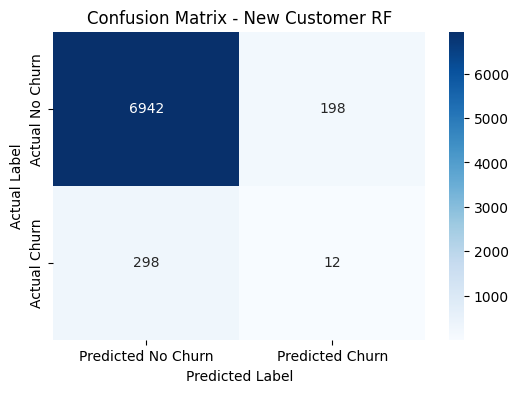



Evaluating Established Customer Model (Random Forest Baseline) ...
Evaluation Report for Established Customer RF
              precision    recall  f1-score   support

No Churn (0)       0.97      0.99      0.98     67328
   Churn (1)       0.59      0.32      0.42      2810

    accuracy                           0.96     70138
   macro avg       0.78      0.66      0.70     70138
weighted avg       0.96      0.96      0.96     70138

ROC AUC Score: 0.7615
Precision-Recall Curve AUC (PRC AUC): 0.4083

 Confusion Matrix:


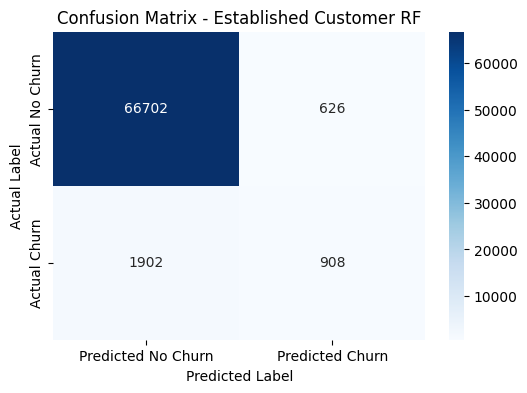

In [51]:
from sklearn.metrics import (classification_report, roc_auc_score,
                            confusion_matrix, precision_recall_curve, auc,
                            f1_score, precision_score, recall_score)

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name = "Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f'Evaluation Report for {model_name}')
    print(classification_report(y_test, y_pred, target_names = ['No Churn (0)', 'Churn (1)']))

    roc_auc = roc_auc_score(y_test, y_prob)
    print(f'ROC AUC Score: {roc_auc:.4f}')

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    prc_auc = auc(recall, precision)
    print(f'Precision-Recall Curve AUC (PRC AUC): {prc_auc:.4f}')

    cm = confusion_matrix(y_test, y_pred)
    print("\n Confusion Matrix:")

    plt.figure(figsize = (6,4))
    sns.heatmap(cm, annot = True, fmt='d', cmap='Blues',
               xticklabels = ['Predicted No Churn', 'Predicted Churn'],
               yticklabels = ['Actual No Churn', 'Actual Churn'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(""* (len(model_name) +24))

    return {
        'roc_auc': roc_auc,
        'prc_auc': prc_auc,
        'f1_churn': f1_score(y_test, y_pred, pos_label=1),
        'recall_churn': recall_score(y_test, y_pred, pos_label=1),
        'precision_churn': precision_score(y_test, y_pred, pos_label=1)
    }

print("Evaluating New Customer Model (Random Forest Baseline)...")
new_model_metrics = evaluate_model(new_model, X_test, y_test, 'New Customer RF')

print("\nEvaluating Established Customer Model (Random Forest Baseline) ...")
established_model_metrics = evaluate_model(established_model, X_test_est, y_test_est, "Established Customer RF")

baseline_metrics = {
    'New RF': new_model_metrics,
    'Established RF': established_model_metrics
}


Calculated scale_pos_weight for Established XGBoost: 23.96

Training default XGBoost model for Established Customers...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:18:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "objectives" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating Established Customer Model (XGBoost Default)...
Evaluation Report for Established Customer XGB
              precision    recall  f1-score   support

No Churn (0)       0.98      0.86      0.92     67328
   Churn (1)       0.15      0.59      0.24      2810

    accuracy                           0.85     70138
   macro avg       0.57      0.73      0.58     70138
weighted avg       0.95      0.85      0.89     70138

ROC AUC Score: 0.8201
Precision-Recall Curve AUC (PRC AUC): 0.4760

 Confusion Matrix:


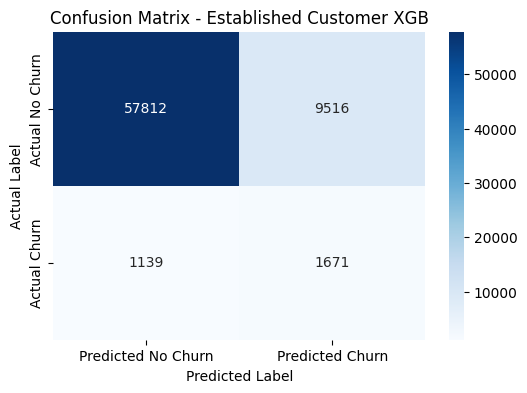

In [52]:
# XGBoost

neg_count_est = (y_train_est == 0).sum()
pos_count_est = (y_train_est == 1).sum()
scale_pos_weight_est = neg_count_est / pos_count_est
print(f'\nCalculated scale_pos_weight for Established XGBoost: {scale_pos_weight_est:.2f}')

xgb_model_est = xgb.XGBClassifier(
    objectives = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    scale_pos_weight = scale_pos_weight_est,
    random_state = 0
)

print('\nTraining default XGBoost model for Established Customers...')
xgb_model_est.fit(X_train_est, y_train_est)

print('\nEvaluating Established Customer Model (XGBoost Default)...')
xgb_est_metrics = evaluate_model(xgb_model_est, X_test_est, y_test_est, 'Established Customer XGB')